In [20]:
import os
import pickle

import music21
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
pieces = music21.corpus.getComposer('palestrina')

First, parse all the scores and save them as pickled files

In [3]:
scores = [ music21.corpus.parse(piece) for piece in tqdm(pieces) ]

100%|██████████| 1318/1318 [14:56<00:00,  1.47it/s]


In [62]:
len(scores)

1318

In [23]:
for i, score in enumerate(tqdm(scores)):
    with open('{}.pkl'.format(os.path.basename(pieces[i])), 'wb') as score_file:
        pickle.dump(score, score_file)

100%|██████████| 1318/1318 [02:03<00:00, 10.70it/s]


Now let's take a look at the distribution of parts

In [24]:
def nb_parts(score):
    return len(list(filter(lambda x: isinstance(x, music21.stream.Part), score)))

In [26]:
parts = np.array([nb_parts(score) for score in tqdm(scores)])

100%|██████████| 1318/1318 [00:00<00:00, 7888.38it/s]


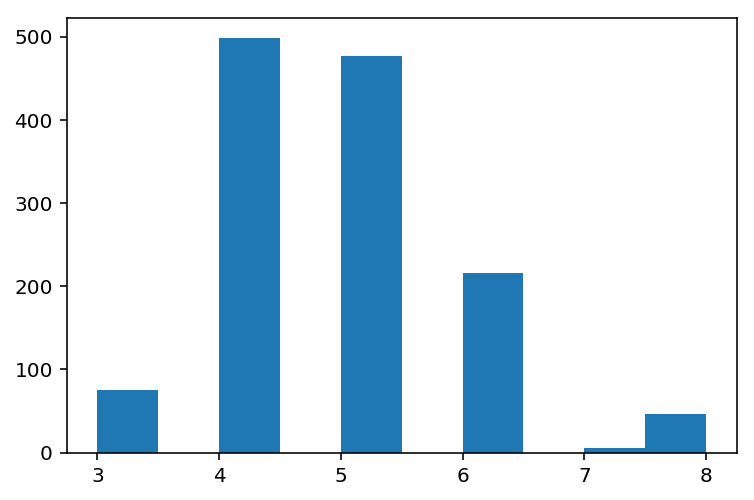

In [28]:
plt.hist(parts)
plt.show()

Now, let's look at the distribution of keys

In [55]:
keys = [s.analyze('key') for s in tqdm(scores)]



  0%|          | 0/1318 [00:00<?, ?it/s]

  0%|          | 2/1318 [00:00<01:13, 17.92it/s]

  4%|▍         | 54/1318 [00:26<10:09,  2.07it/s]


  1%|          | 7/1318 [00:16<52:11,  2.39s/it]

  1%|          | 9/1318 [00:16<40:51,  1.87s/it]

  1%|          | 11/1318 [00:17<33:40,  1.55s/it]

  1%|          | 13/1318 [00:17<28:42,  1.32s/it]

  1%|          | 15/1318 [00:17<24:59,  1.15s/it]

  1%|▏         | 18/1318 [00:17<20:56,  1.03it/s]

  2%|▏         | 20/1318 [00:17<18:56,  1.14it/s]

  2%|▏         | 22/1318 [00:17<17:18,  1.25it/s]

  2%|▏         | 25/1318 [00:17<15:18,  1.41it/s]

  2%|▏         | 28/1318 [00:17<13:43,  1.57it/s]

  2%|▏         | 31/1318 [00:18<12:27,  1.72it/s]

  3%|▎         | 34/1318 [00:18<11:24,  1.87it/s]

  3%|▎         | 37/1318 [00:18<10:32,  2.03it/s]

  3%|▎         | 40/1318 [00:18<09:47,  2.17it/s]

  3%|▎         | 43/1318 [00:18<09:09,  2.32it/s]

  3%|▎         | 46/1318 [00:18<08:35,  2.47it/s]

  4%|▎         | 49/1318 [00:18<08:06,  

 31%|███       | 411/1318 [00:34<01:15, 11.95it/s]

 31%|███▏      | 414/1318 [00:34<01:15, 11.99it/s]

 32%|███▏      | 417/1318 [00:34<01:14, 12.04it/s]

 32%|███▏      | 420/1318 [00:34<01:14, 12.09it/s]

 32%|███▏      | 423/1318 [00:34<01:13, 12.13it/s]

 32%|███▏      | 426/1318 [00:35<01:13, 12.17it/s]

 33%|███▎      | 429/1318 [00:35<01:12, 12.20it/s]

 33%|███▎      | 432/1318 [00:35<01:12, 12.23it/s]

 33%|███▎      | 435/1318 [00:35<01:11, 12.27it/s]

 33%|███▎      | 438/1318 [00:35<01:11, 12.30it/s]

 33%|███▎      | 441/1318 [00:35<01:11, 12.34it/s]

 34%|███▎      | 444/1318 [00:35<01:10, 12.37it/s]

 34%|███▍      | 447/1318 [00:36<01:10, 12.38it/s]

 34%|███▍      | 449/1318 [00:36<01:10, 12.39it/s]

 34%|███▍      | 451/1318 [00:36<01:09, 12.39it/s]

 34%|███▍      | 453/1318 [00:36<01:09, 12.41it/s]

 35%|███▍      | 455/1318 [00:36<01:09, 12.42it/s]

 35%|███▍      | 458/1318 [00:36<01:09, 12.46it/s]

 35%|███▍      | 460/1318 [00:36<01:08, 12.47it/s]

 35%|███▌   

 57%|█████▋    | 748/1318 [00:53<00:40, 14.01it/s]

 57%|█████▋    | 750/1318 [00:53<00:40, 14.00it/s]

 57%|█████▋    | 752/1318 [00:53<00:40, 14.00it/s]

 57%|█████▋    | 755/1318 [00:53<00:40, 14.01it/s]

 57%|█████▋    | 757/1318 [00:54<00:40, 14.01it/s]

 58%|█████▊    | 759/1318 [00:54<00:39, 13.99it/s]

 58%|█████▊    | 761/1318 [00:54<00:39, 13.99it/s]

 58%|█████▊    | 763/1318 [00:54<00:39, 14.00it/s]

 58%|█████▊    | 766/1318 [00:54<00:39, 14.02it/s]

 58%|█████▊    | 769/1318 [00:54<00:39, 14.05it/s]

 59%|█████▊    | 772/1318 [00:54<00:38, 14.07it/s]

 59%|█████▉    | 775/1318 [00:55<00:38, 14.08it/s]

 59%|█████▉    | 778/1318 [00:55<00:38, 14.11it/s]

 59%|█████▉    | 781/1318 [00:55<00:38, 14.13it/s]

 59%|█████▉    | 784/1318 [00:55<00:37, 14.14it/s]

 60%|█████▉    | 787/1318 [00:55<00:37, 14.17it/s]

 60%|█████▉    | 790/1318 [00:55<00:37, 14.18it/s]

 60%|██████    | 793/1318 [00:55<00:36, 14.19it/s]

 60%|██████    | 796/1318 [00:56<00:36, 14.20it/s]

 61%|██████ 

 80%|████████  | 1059/1318 [01:13<00:17, 14.50it/s]

 81%|████████  | 1061/1318 [01:13<00:17, 14.51it/s]

 81%|████████  | 1063/1318 [01:13<00:17, 14.52it/s]

 81%|████████  | 1066/1318 [01:13<00:17, 14.53it/s]

 81%|████████  | 1069/1318 [01:13<00:17, 14.54it/s]

 81%|████████▏ | 1072/1318 [01:13<00:16, 14.56it/s]

 82%|████████▏ | 1075/1318 [01:13<00:16, 14.57it/s]

 82%|████████▏ | 1078/1318 [01:13<00:16, 14.58it/s]

 82%|████████▏ | 1081/1318 [01:14<00:16, 14.59it/s]

 82%|████████▏ | 1084/1318 [01:14<00:16, 14.61it/s]

 82%|████████▏ | 1087/1318 [01:14<00:15, 14.62it/s]

 83%|████████▎ | 1090/1318 [01:14<00:15, 14.64it/s]

 83%|████████▎ | 1093/1318 [01:14<00:15, 14.65it/s]

 83%|████████▎ | 1096/1318 [01:14<00:15, 14.66it/s]

 83%|████████▎ | 1099/1318 [01:14<00:14, 14.67it/s]

 84%|████████▎ | 1102/1318 [01:15<00:14, 14.69it/s]

 84%|████████▍ | 1105/1318 [01:15<00:14, 14.70it/s]

 84%|████████▍ | 1108/1318 [01:15<00:14, 14.72it/s]

 84%|████████▍ | 1111/1318 [01:15<00:14, 14.73

In [56]:
tonics = [k.tonic.fullName for k in keys]

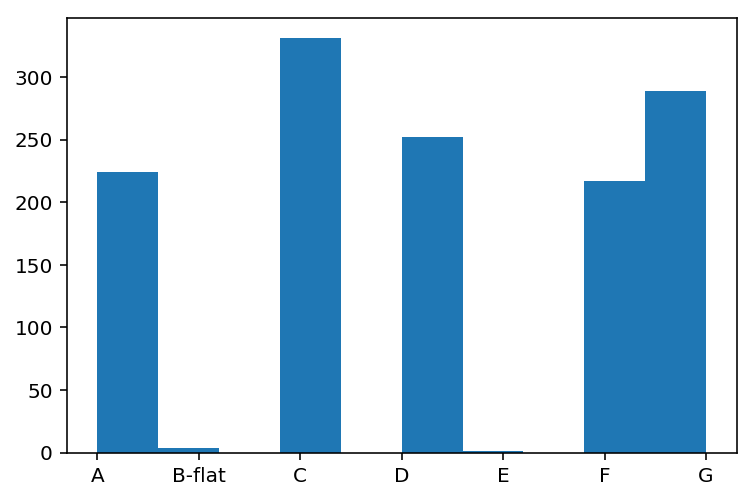

In [58]:
plt.hist(tonics)
plt.show()

In [60]:
len(np.unique(tonics))

7

In [63]:
len(np.unique(tonics)) * len(scores)

9226

Let's look at the notes in a score and figure out how to vectorize it.

In [65]:
s = scores[0]

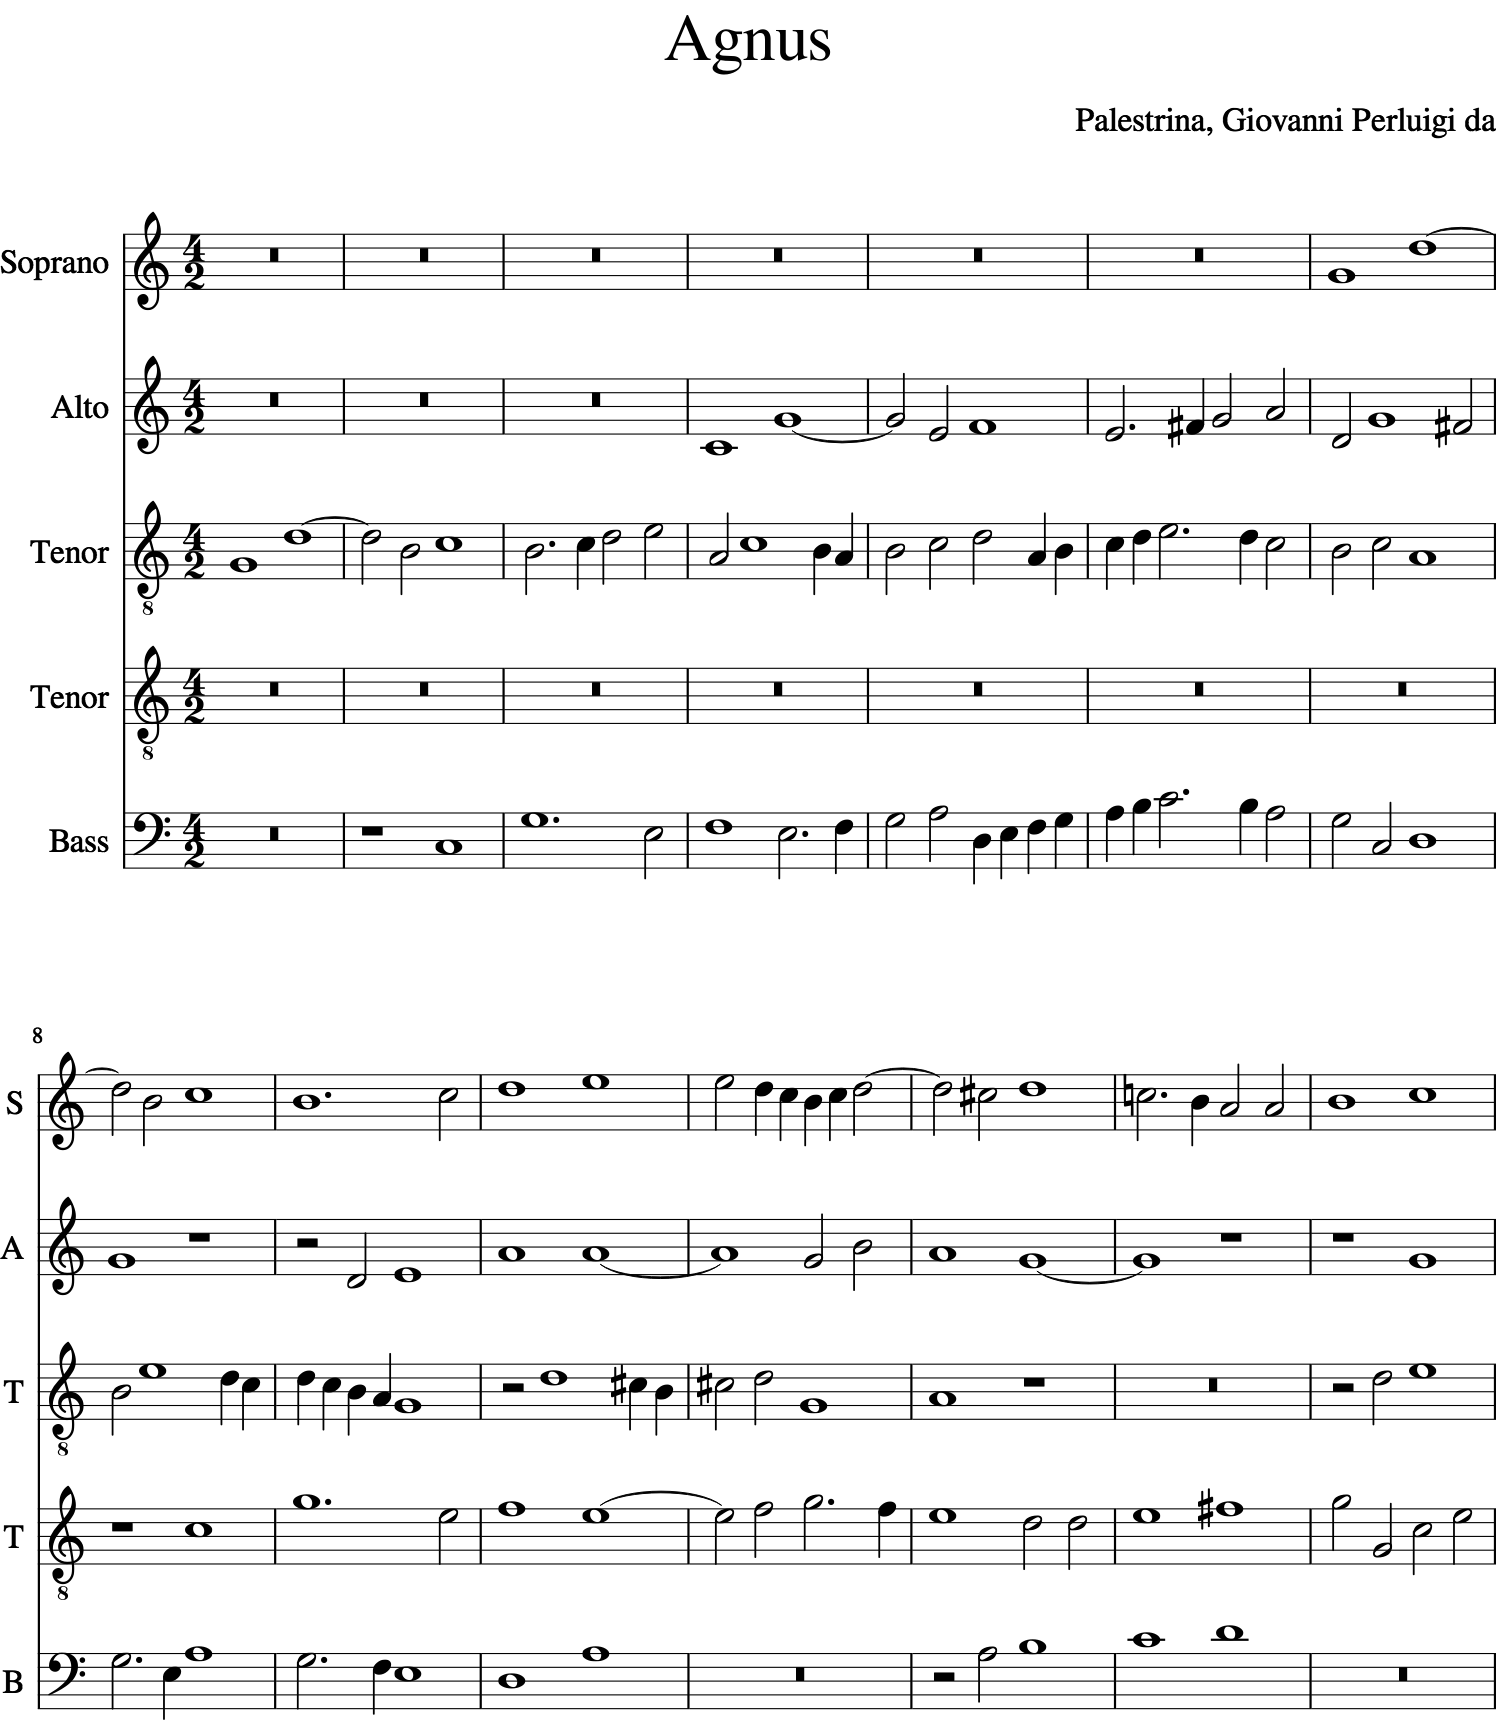

In [79]:
s.show()

In [69]:
list(s)

 <music21.stream.Part spine_4>,
 <music21.stream.Part spine_3>,
 <music21.stream.Part spine_2>,
 <music21.stream.Part spine_1>,
 <music21.stream.Part spine_0>,
 <music21.humdrum.spineParser.GlobalReference CDT "1525/^1526/-1594/2/2">,
 <music21.humdrum.spineParser.GlobalReference AGN "Mass (Paraphrase)">,
 <music21.humdrum.spineParser.GlobalReference AST "renaissance, vocal">,
 <music21.humdrum.spineParser.GlobalReference ASW "Gregorian Mass">,
 <music21.humdrum.spineParser.GlobalReference PWK "Masses, Book Mantuan I">,
 <music21.humdrum.spineParser.GlobalReference RNB "Cadence finals: D">,
 <music21.humdrum.spineParser.GlobalReference YOR "Le Opere Complete, v. 18, p. 83">,
 <music21.humdrum.spineParser.GlobalReference END "1992//">,
 <music21.humdrum.spineParser.GlobalReference YEN "United States of America">,
 <music21.humdrum.spineParser.GlobalReference YEM "Rights to all derivative electronic formats reserved.">,
 <music21.humdrum.spineParser.GlobalReference YEM "Refer to licensin

In [72]:
parts = list(s.getElementsByClass(music21.stream.Part))

In [74]:
p = parts[0]

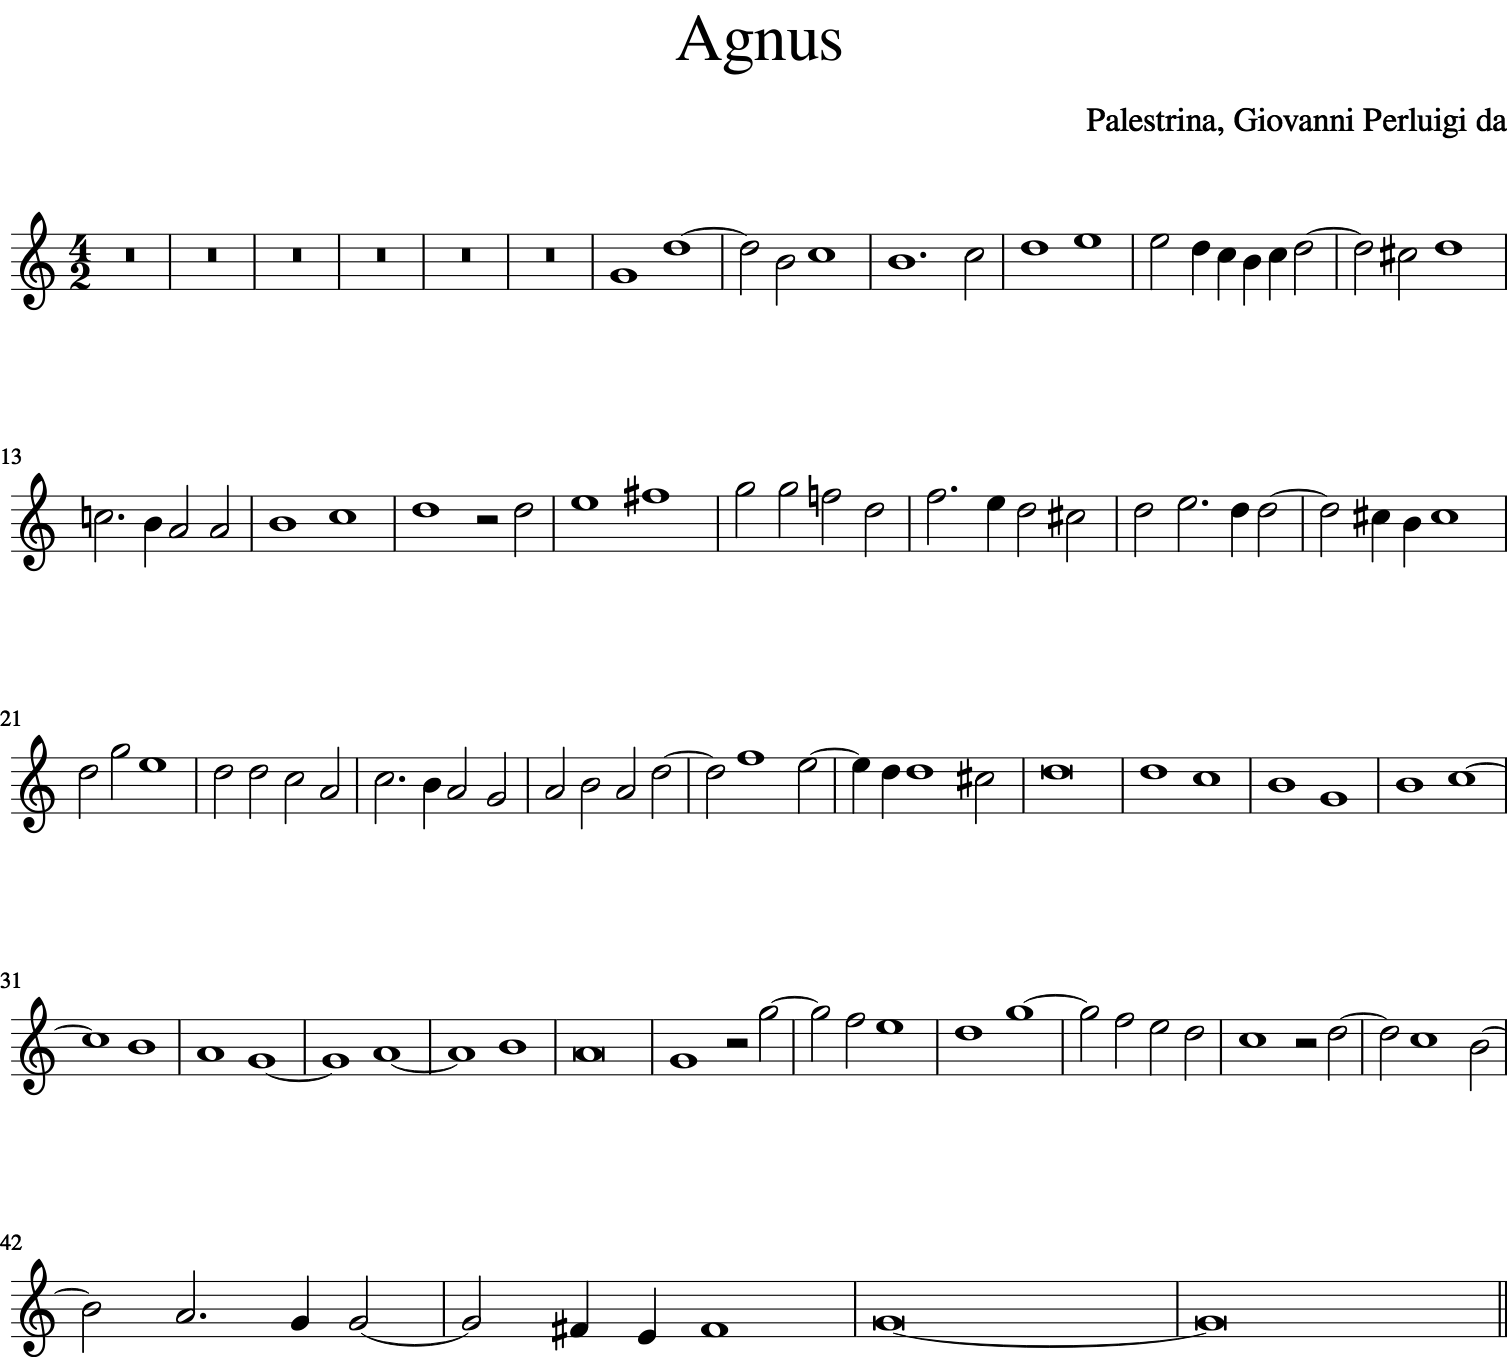

In [80]:
p.show()

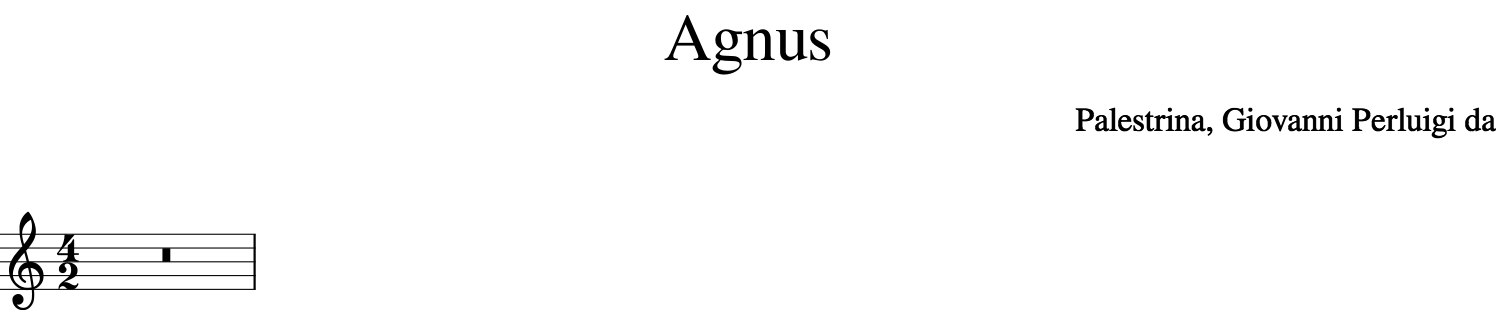

In [94]:
measure1 = p[2]
measure1.show()

In [93]:
measure1.timeSignature

<music21.meter.TimeSignature 4/2>

In [96]:
measure7 = p[9]

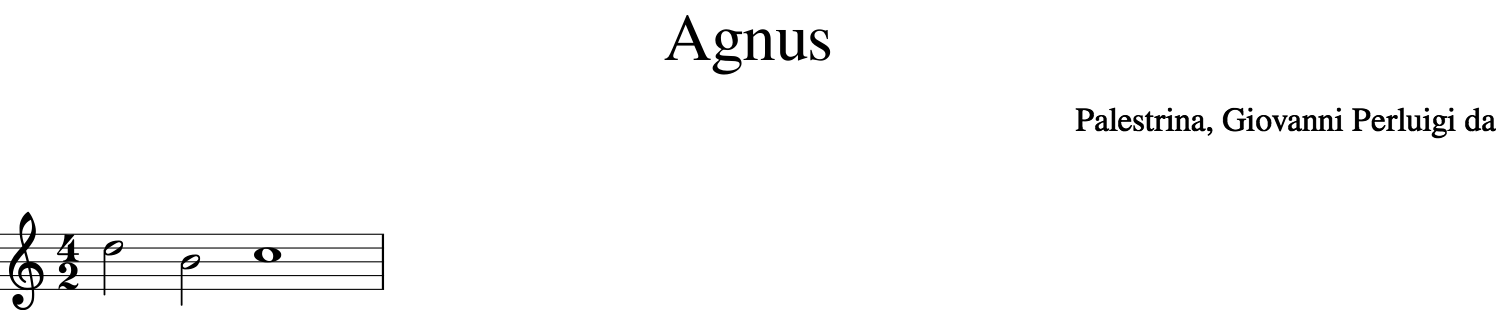

In [97]:
measure7.show()

In [122]:
note = list(measure7)[0]

In [124]:
note.beat

1.0

In [127]:
note.pitch

74